In [1]:
import numpy as np
import pandas as pd
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import re
import os
import imageio
import cv2
%matplotlib inline
%load_ext autoreload
%autoreload 2
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)

In [2]:
size=20
params = {'legend.fontsize': 'large',
          'figure.figsize': (14,7),
          'axes.labelsize': size,
          'axes.titlesize': size*0.75,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75,
          'axes.titlepad': 25}
plt.rcParams.update(params)

# We assume the distribution of iid bernoulli trials is the binomial distribution. We want to find the distribution of the number of healthy people that are infected on Day 1 and the expected number?

## 1. Fixed contact rate which implies that all the healthy pouplation have the same chance of getteing infected equivalent to the infectios transmission rate. This is an extreme case!

In [3]:
def perform_bernoulli_trials(n, p):
    """
    Perform n Bernoulli trials with success probability p
    and return number of successes.
    """
    # Initialize number of successes: n_success
    n_success = 0

    # Perform trials
    for i in range(n):
        # Choose random number between zero and one: random_number
        random_number = np.random.uniform(0, 1)

        # If less than p (transmission rate), it's a success so add one to n_success
        if random_number < p:
            n_success += 1

    return n_success


In [4]:
#run 10000 times
infected_day_1 = []
for i in range(0, 10000):
    result = perform_bernoulli_trials(100,0.02)
    infected_day_1.append(result)

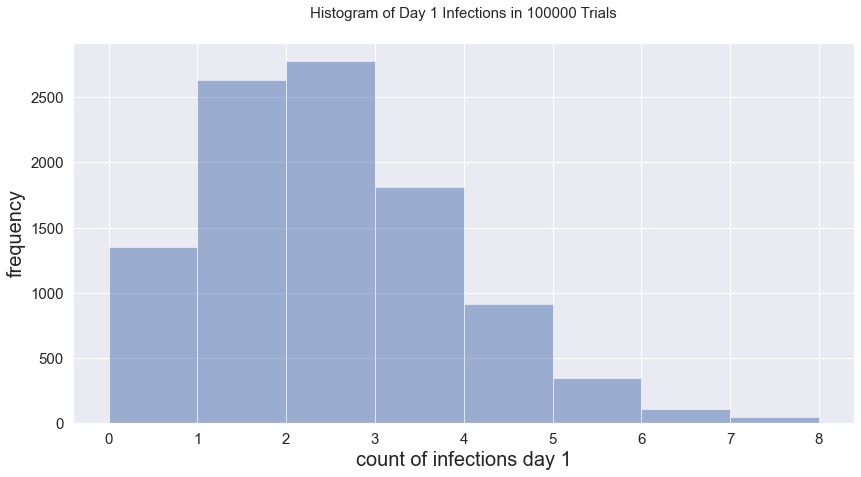

In [5]:
bins = np.arange(0, 9, 1) # fixed bin size

# plt.xlim([0, 5])
# plt.ylim([0,10000])

plt.hist(infected_day_1, bins=bins, alpha=0.5)
plt.title('Histogram of Day 1 Infections in 100000 Trials')
plt.xlabel('count of infections day 1')
plt.ylabel('frequency')

plt.show()

In [6]:
print('% 0.3f' % (np.mean(infected_day_1)))

 2.006


This is what we expect with p=0.02 (2 healthy people are expected to be infected on day 1).

## 2. Now let us generalize to random contact rate

In [7]:
def perform_bernoulli_trials_2(init_susceptible, init_infected, infect_transmission_rate, 
                               fixed_contact, min_rand_contact, max_rand_contact, num_trials):
    """
    Perform n Bernoulli trials with success probability p
    and return number of successes.
    """
    infect_counts = [] 
    for t in range(num_trials):
        
        # Initialize number of successes: n_success
        n_success = 0
        
        # Perform trials
        for i in range(init_susceptible):

            # draw a uniform integer for number of contacts and add it to a fixed contact number. This fixed contact is used later for sensitivity analysis.
            contact_rate = fixed_contact + np.random.randint(min_rand_contact, max_rand_contact)        
            prob_get_infected = 1 - (1 - infect_transmission_rate * init_infected /
                                     (init_susceptible - 1)) ** contact_rate

            # Choose random number between zero and one: random_number
            random_number = np.random.uniform(0, 1)
        
            # If less than p, it's a success so add one to n_success
            if random_number < prob_get_infected:
                n_success += 1

        infect_counts.append(n_success)
    
    return infect_counts


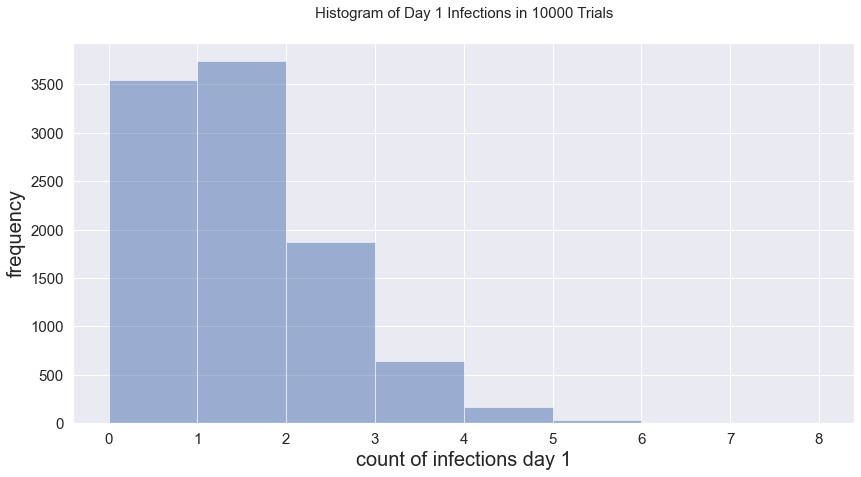

In [8]:
#run 10000 times
num_trials = 10000
infected_day_1 = perform_bernoulli_trials_2(init_susceptible = 100, init_infected=1, infect_transmission_rate=0.02, 
                                            fixed_contact=0, min_rand_contact=1, max_rand_contact=101, num_trials = num_trials)

bins = np.arange(0, 9, 1) # fixed bin size

# plt.xlim([0, 5])
# plt.ylim([0,10000])

plt.hist(infected_day_1, bins=bins, alpha=0.5)
plt.title('Histogram of Day 1 Infections in ' + str(num_trials) + ' Trials')
plt.xlabel('count of infections day 1')
plt.ylabel('frequency')

plt.show()

In [9]:
print('% 0.3f' % (np.mean(infected_day_1)))

 1.028


This makes sense as the expected contact rate is 50 (expected value of uniform distribution) which is half of the previous 100 contact rate as such number of infected people should also be half.

## 3. How does it spread over days?

In [10]:
def perform_bernoulli_trials(n_susceptible, n_infected, infect_transmission_rate,
                             fixed_contact, min_rand_contact, max_rand_contact):
    """
    Perform n Bernoulli trials with success probability p
    and return number of successes.
    """

    # Initialize number of successes: n_success
    n_success = 0

    # Perform trials
    for i in range(n_susceptible):

        # combines a fixed (minimum) contact and random contact number
        contact_rate = fixed_contact + np.random.randint(min_rand_contact, max_rand_contact)
        prob_get_infected = 1 - (1 - infect_transmission_rate * n_infected /
                                 (n_susceptible - 1 + 0.001)) ** contact_rate

        # Choose random number between zero and one
        random_number = np.random.uniform(0, 1)

        # If less than p, it's a success so add one to n_success
        if random_number < prob_get_infected:
            n_success += 1

    return n_success


def simulate_pandemic(n_susceptible, n_infected, n_recovered, infect_transmission_rate,
                      infectious_period, fixed_contact, min_rand_contact, max_rand_contact, obs_days):
    
    S = np.zeros(obs_days + 1)
    I = np.zeros(obs_days + 1)
    I_day = np.zeros(obs_days + 1)
    R = np.zeros(obs_days + 1)

    # Initial condition
    I[0] = n_infected  # how many individuals at time t are currently infected, initially 1 
    I_day[0] = n_infected  # only who got infected ON THIS DAY
    S[0] = n_susceptible  # how many individuals at time t can get infected, initially 20
    R[0] = n_recovered  # how many individuals at time t are removed (recovered and immune?)

    # Step equations forward in time
    for day in range(1, obs_days + 1):
        if S[day - 1] and I[day - 1] != 0:
            infected = perform_bernoulli_trials(int(S[day - 1]), I[day - 1], infect_transmission_rate,
                                                fixed_contact, min_rand_contact, max_rand_contact)
        else:
            infected = 0

        I_day[day] = infected
        S[day] = S[day - 1] - infected  # available at start minus infected today
        R[day] = R[day - 1] + I_day[
            day - infectious_period]  # recovered yesterday + infected infectious_period days prior
        I[day] = np.sum([I_day[day - d] for d in range(infectious_period)])

    return S, I, R


def run(n_susceptible, n_infected, n_recovered, infect_transmission_rate,
        infectious_period, fixed_contact, min_rand_contact, max_rand_contact, obs_days, n_trails):
    S_dist = []
    I_dist = []
    R_dist = []
    for i in range(0, n_trails):
        si, ii, ri = simulate_pandemic(n_susceptible, n_infected, n_recovered, infect_transmission_rate,
                                       infectious_period, fixed_contact, min_rand_contact, max_rand_contact, 
                                       obs_days)
        S_dist.append(si)
        I_dist.append(ii)
        R_dist.append(ri)

    return S_dist, I_dist, R_dist


susceptible_population, infected_population, recovered_population = \
    run(n_susceptible=100, n_infected=2, n_recovered=0, infect_transmission_rate=0.02, 
        infectious_period=5, fixed_contact=0, min_rand_contact=1, max_rand_contact=19,
        obs_days=60, n_trails=5000)

# print("Susceptible population is {}".format(susceptible_population))
# print("Infected population is {}".format(infected_population))
# print("Recovered population is {}".format(recovered_population))

In [11]:
total_cases = []
for li in recovered_population:
    total_cases.append(li.max())

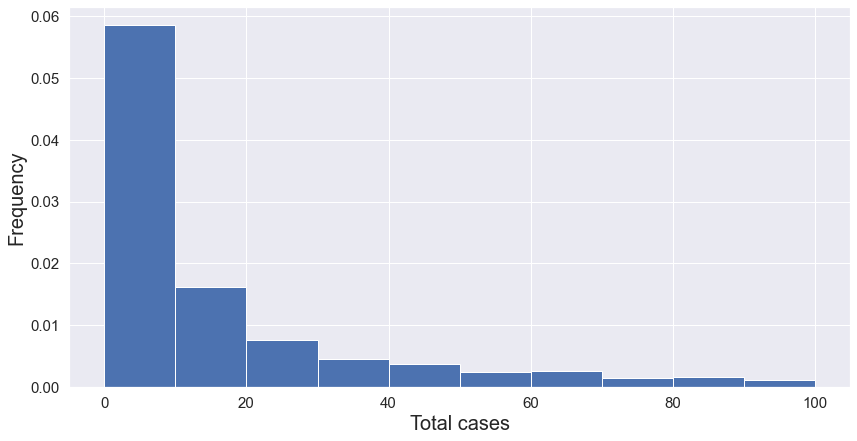

In [12]:
# plt.figure(figsize=(10,8))
plt.hist(total_cases, bins=np.arange(0, 101, 10), density=True);
plt.xlabel('Total cases')
plt.ylabel('Frequency')
plt.show()

In [13]:
# method 1 without need to import ECDF package 
# plt.plot(np.sort(total_cases), np.linspace(0, 1, len(total_cases), endpoint=False)); 

# similar method 2 without need to import ECDF package
# x = np.sort(total_cases)
# y = np.arange(len(x))/float(len(x))
# plt.plot(x, y)

In [14]:
ecdf = ECDF(total_cases)

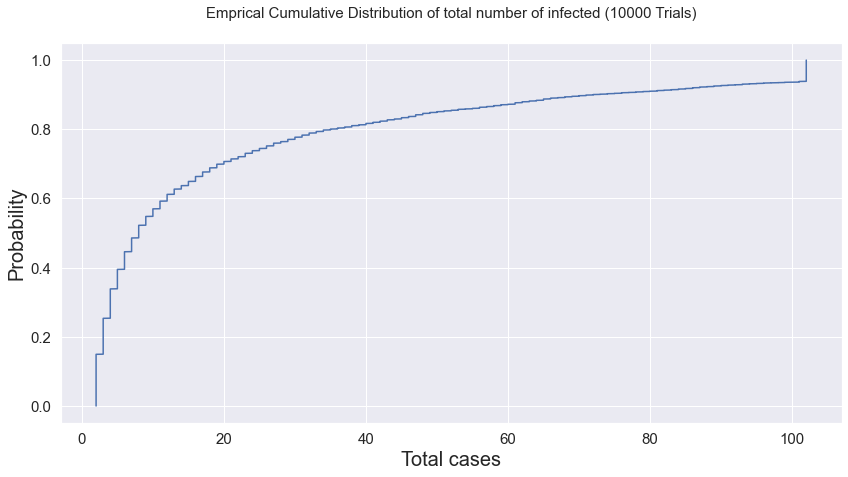

In [15]:
# plot the cdf
plt.plot(ecdf.x, ecdf.y)
plt.title('Emprical Cumulative Distribution of total number of infected (10000 Trials)')
plt.xlabel('Total cases')
plt.ylabel('Probability')
plt.show()

In [16]:
# get cumulative probability for values
print("P(5 percent of population is infecetd): %.3f" % (1 - ecdf(5)))
print("P(10 percent of population is infecetd): %.3f" % (1 - ecdf(10)))
print("P(Extreme case of half of population is infected): %.3f" % (1 - ecdf(50)))

P(5 percent of population is infecetd): 0.605
P(10 percent of population is infecetd): 0.430
P(Extreme case of half of population is infected): 0.149


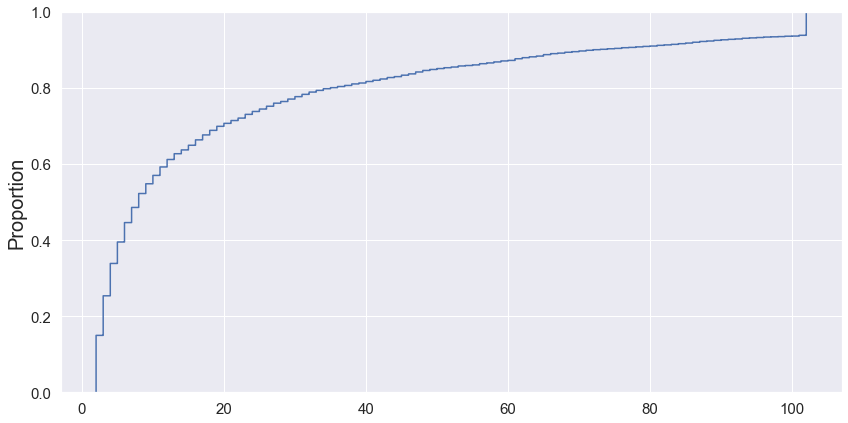

In [17]:
sns.ecdfplot(data=total_cases);

In [18]:
max_daily_cases = []
for li in infected_population:
    max_daily_cases.append(li.max())

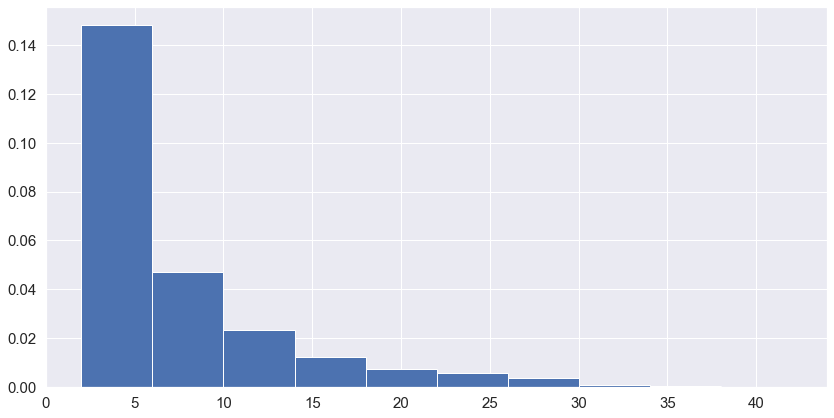

In [19]:
plt.hist(max_daily_cases, density=True);

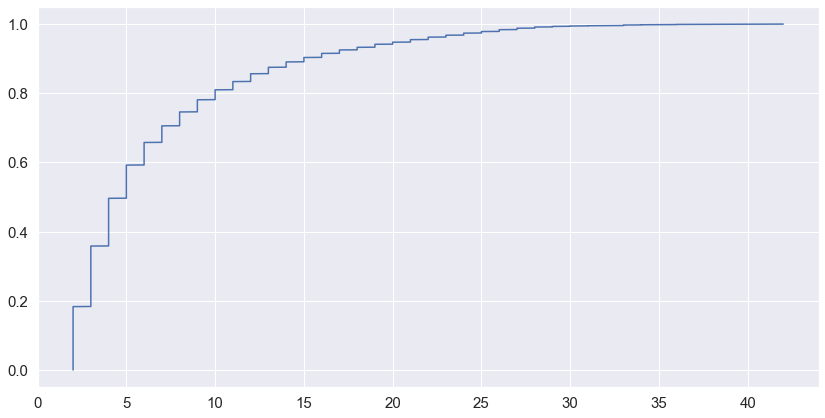

In [20]:
plt.plot(np.sort(max_daily_cases), np.linspace(0, 1, len(max_daily_cases), endpoint=False));

In [21]:
pandemic_end = []
for li in recovered_population:
    pandemic_end.append(li.argmax())

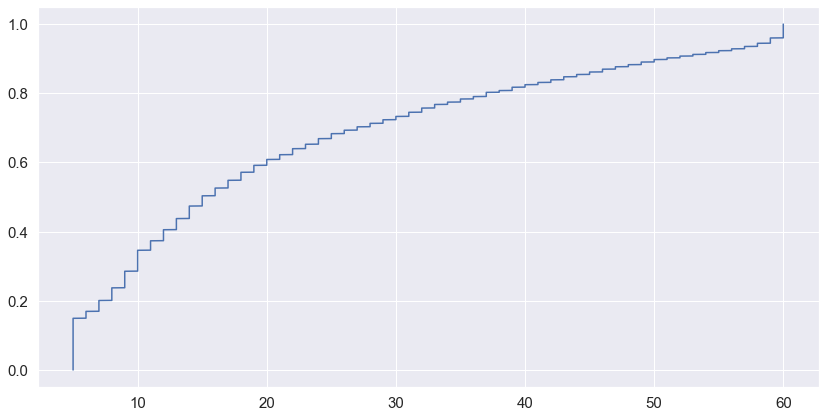

In [22]:
plt.plot(np.sort(pandemic_end), np.linspace(0, 1, len(pandemic_end), endpoint=False));

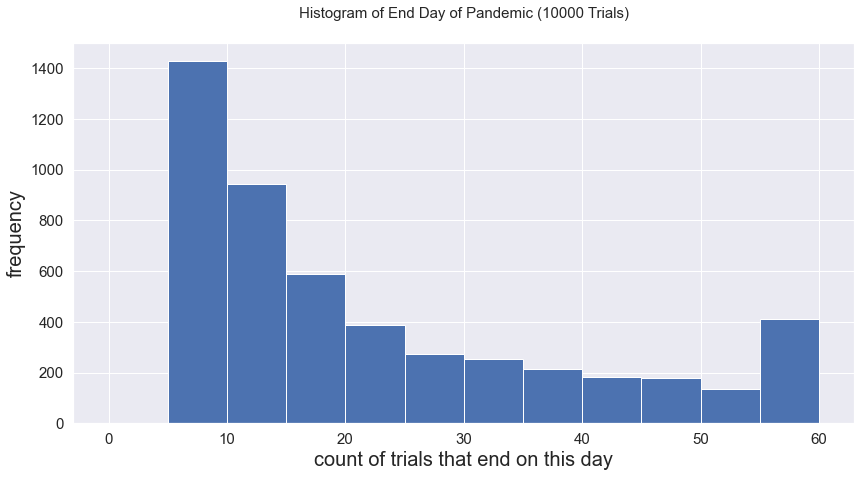

In [23]:
#produce a histogram!
#WHEN DOES IT END?

# plt.xlim([0, 60])
# plt.ylim([0,3000])

plt.hist(pandemic_end, bins=np.arange(0, 61, 5))
plt.title('Histogram of End Day of Pandemic (10000 Trials)')
plt.xlabel('count of trials that end on this day')
plt.ylabel('frequency')

plt.show()

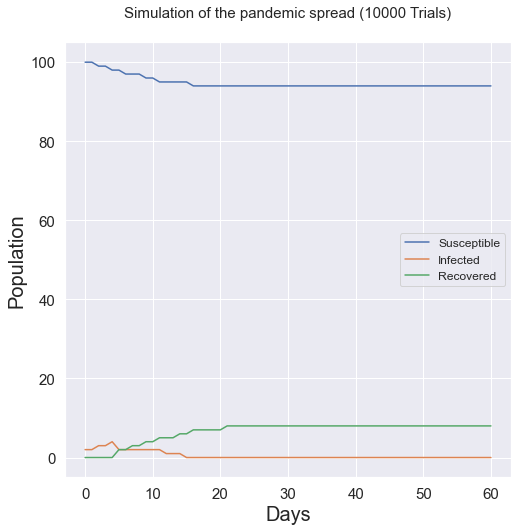

In [24]:
plt.figure(figsize=(8, 8))
plt.plot(np.arange(0, 61), np.median(susceptible_population, axis=0), label = 'Susceptible')
plt.plot(np.arange(0, 61), np.median(infected_population, axis=0), label = 'Infected')
plt.plot(np.arange(0, 61), np.median(recovered_population, axis=0), label = 'Recovered')
plt.xlabel('Days')
plt.ylabel('Population')
plt.legend()
plt.title('Simulation of the pandemic spread (10000 Trials)');

## 4. Contact rate affect

In [25]:
contact_rates = np.arange(1, 16, 2)

susceptible_population = []
infected_population = []
recovered_population = []
total_cases = []
max_daily_cases = []
pandemic_end = []
total_cases_per_contact = []
max_daily_cases_per_contact = []
pandemic_end_per_contact = []

i = 0
for c in contact_rates:
    sp, ip, rp = \
    run(n_susceptible=100, n_infected=2, n_recovered=0, infect_transmission_rate=0.02, 
        infectious_period=5, fixed_contact=c-1, min_rand_contact=1, max_rand_contact=2,
        obs_days=90, n_trails=5000)
    
    susceptible_population.append(sp)
    infected_population.append(ip)
    recovered_population.append(rp)

    total_cases.append([li.max() for li in rp])
    pandemic_end.append([li.argmax() for li in rp])
    max_daily_cases.append([li.max() for li in ip])
    
    i += 1
    total_cases_per_contact.append([li.max() for li in total_cases[i - 1]])
    pandemic_end_per_contact.append([li.max() for li in pandemic_end[i - 1]])
    max_daily_cases_per_contact.append([li.max() for li in max_daily_cases[i - 1]])


In [26]:
d = {
    "contact_rates" : np.arange(1, 16, 2), 
    "80%_quantile_total_cases": [np.quantile(total_cases_per_contact[i], 
                                             .80).astype(int) for i in range(8)],
    "80%_quantile_max_daily_cases": [np.quantile(max_daily_cases_per_contact[i], 
                                                 .80).astype(int) for i in range(8)],
    "80%_quantile_pandemic_end_day": [np.quantile(pandemic_end_per_contact[i],
                                                  .80).astype(int) for i in range(8)]
}
contact_rate_df = pd.DataFrame(d)
contact_rate_df

,contact_rates,80%_quantile_total_cases,80%_quantile_max_daily_cases,80%_quantile_pandemic_end_day
0,1,2,2,5
1,3,4,3,10
2,5,5,4,12
3,7,9,5,17
4,9,26,9,32
5,11,102,25,47
6,13,102,40,40
7,15,102,52,33


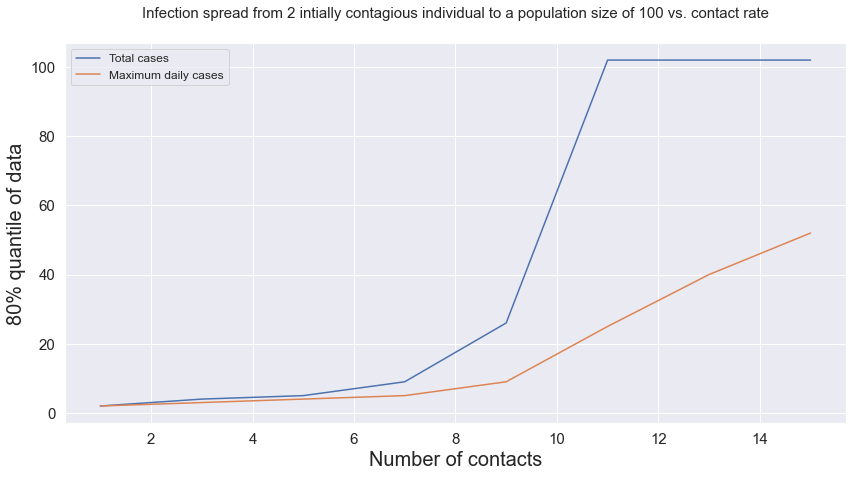

In [27]:
# plt.figure(figsize=(14, 7))
plt.plot(contact_rate_df.contact_rates, contact_rate_df['80%_quantile_total_cases'], 
         label = 'Total cases')
plt.plot(contact_rate_df.contact_rates, contact_rate_df['80%_quantile_max_daily_cases'], 
         label = 'Maximum daily cases')
plt.xlabel("Number of contacts")
plt.ylabel("80% quantile of data")
plt.title("Infection spread from 2 intially contagious individual to a population size of 100 vs. contact rate")
plt.legend()
plt.savefig('SpreadVsContact.png', dpi=300)
plt.show()


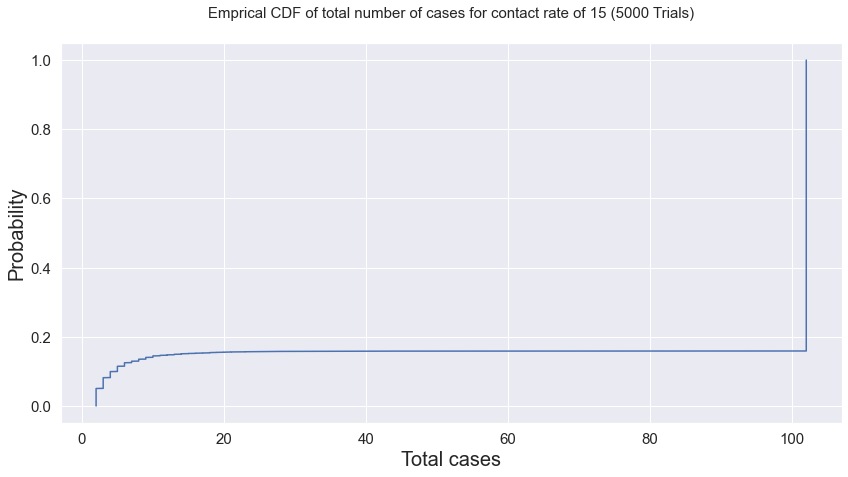

In [28]:
i = 7
ecdf = ECDF(total_cases_per_contact[i])
# plot the cdf
plt.plot(ecdf.x, ecdf.y)
plt.title('Emprical CDF of total number of cases for contact rate of 15 (5000 Trials)')
plt.xlabel('Total cases')
plt.ylabel('Probability')
plt.savefig('ECDF_totalcases_15.png', dpi=300)
plt.show()

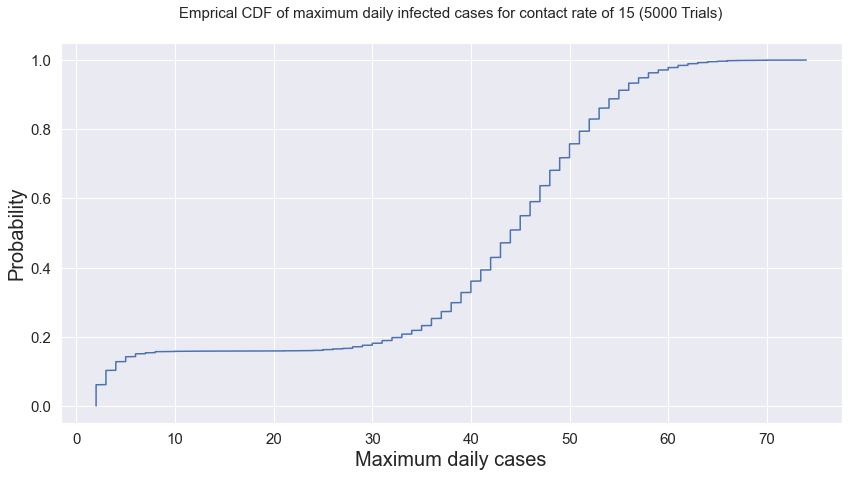

In [29]:
i = 7

ecdf = ECDF(max_daily_cases_per_contact[i])
  
# plot the cdf
plt.plot(ecdf.x, ecdf.y)
plt.title('Emprical CDF of maximum daily infected cases for contact rate of 15 (5000 Trials)')
plt.xlabel('Maximum daily cases')
plt.ylabel('Probability')
plt.savefig('ECDF_maxDailycases_15.png', dpi=300)
plt.show()

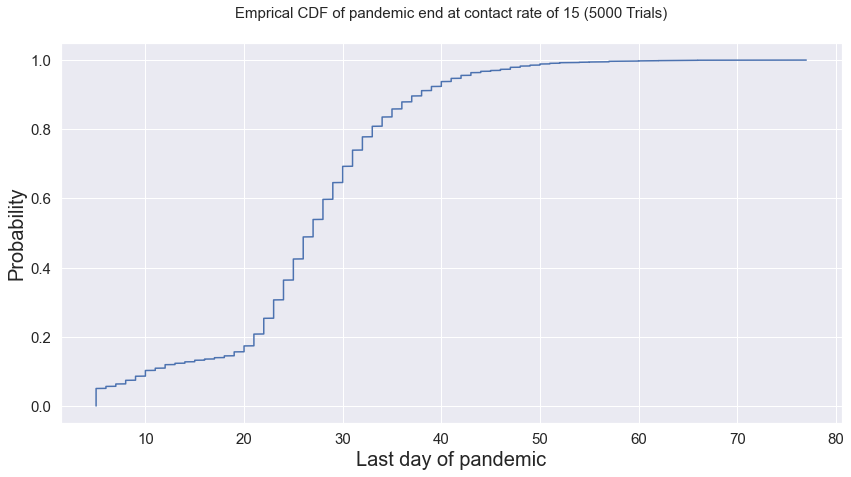

In [30]:
i = 7
   
ecdf = ECDF(pandemic_end_per_contact[i])
# plot the cdf
plt.plot(ecdf.x, ecdf.y)
plt.title('Emprical CDF of pandemic end at contact rate of 15 (5000 Trials)')
plt.xlabel('Last day of pandemic')
plt.ylabel('Probability')
plt.savefig('ECDF_pandemicEndcases_15.png', dpi=300)
plt.show()

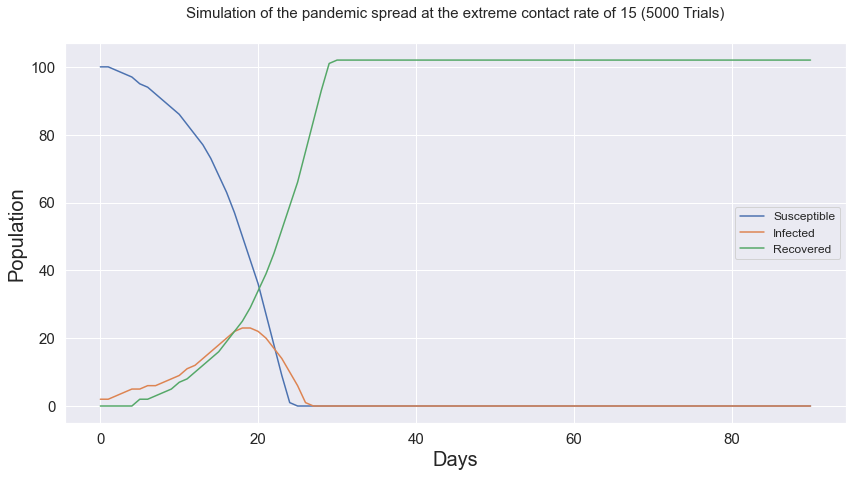

In [31]:
i = 7

plt.plot(np.arange(0, 91), np.median(susceptible_population[i], axis=0), label = 'Susceptible')
plt.plot(np.arange(0, 91), np.median(infected_population[i], axis=0), label = 'Infected')
plt.plot(np.arange(0, 91), np.median(recovered_population[i], axis=0), label = 'Recovered')
plt.xlabel('Days')
plt.ylabel('Population')
plt.legend()
plt.title('Simulation of the pandemic spread at the extreme contact rate of 15 (5000 Trials)')
plt.savefig('SIR_15.png', dpi=300)
plt.show()

# Make time lapse from results

In [32]:
pwd

'C:\\Users\\mghan\\OneDrive - Georgia Institute of Technology\\Documents\\GTOMSA\\Simulation\\Project'

In [59]:
image_folder = 'C:\\Users\\mghan\\OneDrive - Georgia Institute of Technology\\Documents\\GTOMSA\\Simulation\\Project\\images'
video_name = 'results.mp4'

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]

def natural_sort_key(s, _nsre=re.compile('([0-9]+)')):
    return [
        int(text)
        if text.isdigit() else text.lower()
        for text in _nsre.split(s)]

sorted_images = sorted(images, key=natural_sort_key)

frame = cv2.imread(os.path.join(image_folder, sorted_images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 1, (width,height))

for image in sorted_images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()